In [1]:
import numpy as np
import scipy.ndimage
import scipy.interpolate
import skimage.io
import matplotlib.pyplot as plt

import maxflow

shape: (1024, 350, 350)


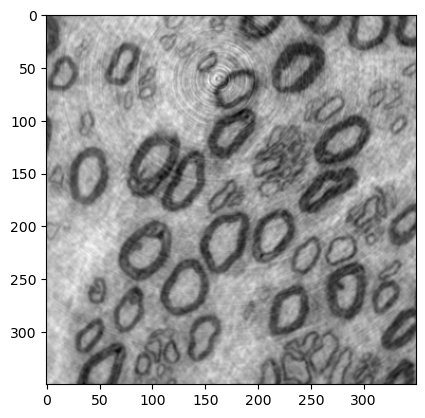

In [2]:
# Load data

im = skimage.io.imread('nerves_part.tiff')/255
print('shape:', im.shape)

fig, ax = plt.subplots(1,1)
ax.imshow(im[0,:,:], cmap=plt.cm.gray)
plt.show()

In [13]:
%matplotlib qt

Text(0.5, 1.0, 'Intensity histogram for all slices')

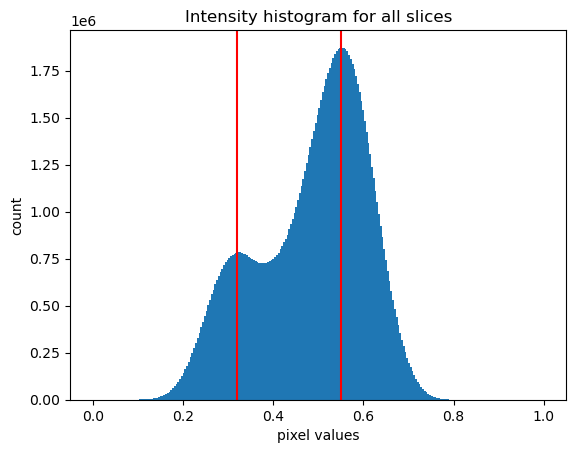

In [3]:
# Display histogram

edges = np.linspace(0, 1, 257)
fig, ax = plt.subplots()
ax.hist(im.ravel(), edges)
ax.axvline(x=0.32,color='r')
ax.axvline(x=0.55,color='r')
ax.set_xlabel('pixel values')
ax.set_ylabel('count')
ax.set_title('Intensity histogram for all slices')

In [4]:
# Find position of the 2 peaks in the histogram
mu = np.array([0.32, 0.55])

# other parameters
beta_xy  = 0.005
beta_z = 0.25 #0.02
nslice = 200  # dont use a too large number, computationally demanding

In [5]:
# contruct 3D graph and compute cut

U = np.stack([(im[0:nslice]-mu[i])**2 for i in range(len(mu))],axis=3)
S0 = np.argmin(U,axis=3)

g = maxflow.Graph[float]()
nodeids = g.add_grid_nodes(im[0:nslice].shape)

structure = np.array(
        [[[0, 0, 0],
          [0, beta_z, 0],
          [0, 0, 0]],
         [[0, 0, 0],
          [0, 0, beta_xy],
          [0, beta_xy, 0]],
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]]
    )
g.add_grid_edges(nodeids, structure=structure, symmetric=True)
    
g.add_grid_tedges(nodeids, U[:,:,:,1], U[:,:,:,0])

#  solving
g.maxflow()
S = g.get_grid_segments(nodeids)
S = ~S

Text(0.5, 1.0, 'max posterior')

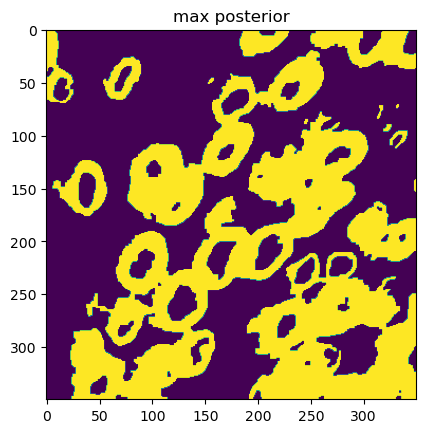

In [6]:
# display first slice of the segmentation1
fig, ax = plt.subplots()
ax.imshow(S[3])
ax.set_title('max posterior')

In [7]:
# save segmentation
test = S.astype('uint8')*255
a = str(beta_xy).replace('.', ',')
b = str(beta_z).replace('.', ',')
skimage.io.imsave(f'RMF_{a}_{b}.tiff', test)

In [17]:
# open segmentation
S = skimage.io.imread('RMF_0,005_0,25.tiff')/255
print('shape:', S.shape)

fig, ax = plt.subplots(1,1)
ax.imshow(S[0,:,:], cmap=plt.cm.gray)
plt.show()

shape: (200, 350, 350)


In [25]:
# Compute Myelin density
np.sum(S)/(S.shape[0]*S.shape[1]*S.shape[2])

0.37731620408163263

In [27]:
## Compute Nerve density count (Blob analyis)

In [28]:
from skimage import io, color, morphology
from skimage import measure
from skimage.color import label2rgb

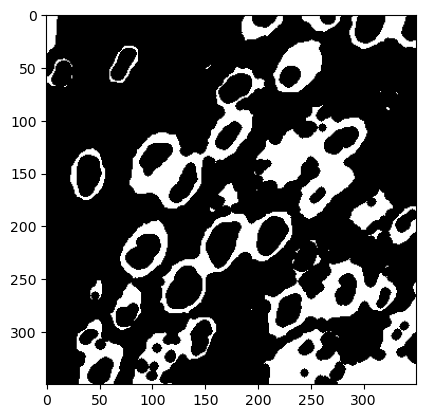

In [119]:
# Morphological filtering

footprint = morphology.disk(3)
im_process = morphology.binary_closing(S[0,:,:], morphology.disk(1))
im_process = morphology.erosion(im_process, morphology.disk(3))

fig, ax = plt.subplots(1,1)
ax.imshow(im_process, cmap=plt.cm.gray)
plt.show()

Number of labels: 52


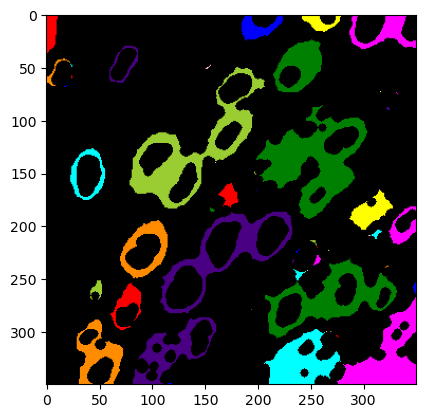

In [120]:
# Blob counting 
label_img = measure.label(im_process)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

im_blob = label2rgb(label_img)

fig, ax = plt.subplots(1,1)
ax.imshow(im_blob, cmap=plt.cm.gray)
plt.show()

In [121]:
# compute the nb of labels in each slice and take the mean
NLABELS = np.zeros(S.shape[0])
for i in range(S.shape[0]):
    im_process = morphology.binary_closing(S[i,:,:], morphology.disk(1))
    im_process = morphology.erosion(im_process, morphology.disk(3))
    
    label_img = measure.label(im_process)
    n_labels = label_img.max()
    NLABELS[i] = n_labels

In [122]:
np.mean(NLABELS)

43.655